# Head



---



In [1]:
!pip install geopandas
!pip install shapely
!pip install momepy
!pip install pandas
!pip install dask
!pip install Orange3
!pip install pygeos
# NOTE: momepy.Tessellation() ONLY works if Momepy was installed from Conda!!!
# -> condacolab by Jaime Rodríguez-Guerra: https://github.com/jaimergp/condacolab
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge momepy
!conda install dask

     |████████████████████████████████| 1.0MB 6.5MB/s 
     |████████████████████████████████| 15.3MB 268kB/s 
     |████████████████████████████████| 6.6MB 33.6MB/s 
     |████████████████████████████████| 245kB 5.3MB/s 
     |████████████████████████████████| 2.0MB 8.6MB/s 
     |████████████████████████████████| 2.4MB 29.6MB/s 
     |████████████████████████████████| 24.4MB 175kB/s 
     |████████████████████████████████| 153kB 39.3MB/s 
     |████████████████████████████████| 2.3MB 26.9MB/s 
     |████████████████████████████████| 491kB 26.9MB/s 
     |████████████████████████████████| 942kB 34.9MB/s 
     |████████████████████████████████| 8.3MB 35.5MB/s 
     |████████████████████████████████| 71kB 4.9MB/s 
     |████████████████████████████████| 235kB 40.4MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 256kB 47.6MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 59.9MB 83kB/s 
  

In [1]:
import momepy as mp
import geopandas as gpd
import pandas as pd
import time 
import numpy as np
import shapely
import warnings
import dask
import dask.dataframe as daskdf
import libpysal
from tqdm.auto import tqdm
from collections import Counter

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Declaration of variables

In [8]:
###### Variables ######

update_mode = False  # if True, the already modified .shp will be loaded instead of the plane new one
precision = 5  # precision of calculated values
do_tessellation = True  # calculate time demanding tessellation
do_enclosed_tess = True  # enclosed tessellation makes only sense if the given data is of higher quality
do_preprocessing = True  # time demandeng MP-preprocessing
minsize = 2  # buildings smaller than this will be cut out by mp.preprocess()
gpd.options.use_pygeos = True  # usding PYGEOS speeds up certain operations
start_time = time.time()  # starting time for time measurement

# data input
infile = '/content/drive/MyDrive/Uni/Geographie/BA/Daten/Hue_buildings_WGS84.geojson'
infile_modified = '/content/drive/MyDrive/Uni/Geographie/BA/Daten/hue_edited_python_colab.shp'
roads_in = '/content/drive/MyDrive/Uni/Geographie/BA/Daten/HUE_osm_roads_free_1.shp'
water_in = '/content/drive/MyDrive/Uni/Geographie/BA/Daten/hue_OSM_water_free.shp'
landuse_in = None #'/content/drive/MyDrive/Uni/Geographie/BA/Daten/HUE_gis_osm_landuse_a_free_1.shp'
townhall_in = None #'/content/drive/MyDrive/Uni/Geographie/BA/Daten/Hue_town_hall.shp'
max_density_spot_in = None #'/content/drive/MyDrive/Uni/Geographie/BA/Daten/hue_max_density_spot.shp'
k_dense_in = None #'/content/drive/MyDrive/Uni/Geographie/BA/Daten/Hue_kernal_density_1km.csv'

# data output
outfile = '/content/drive/MyDrive/Uni/Geographie/BA/Daten/hue_edited_python_colab.shp'
tess_out = '/content/drive/MyDrive/Uni/Geographie/BA/Daten/hue_tessellation.shp'
tess_encl_out = '/content/drive/MyDrive/Uni/Geographie/BA/Daten/hue_tessellation_enclosed.shp'
outfile_classified = '/content/drive/MyDrive/Uni/Geographie/BA/Daten/hue_classified_full.shp'
outfile_blocks = '/content/drive/MyDrive/Uni/Geographie/BA/Daten/Hue_Blocks.shp'

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Declaration of functions

In [11]:
###### Functions ######

def reproject(shp):
    """
    Converts shp to metric CRS if neccesary    
    """
    if shp.crs != 'EPSG:32648':
        print("Reprojecting to EPSG 32648")
        shp = shp.to_crs("EPSG:32648")
    return shp


def msize(gdf, radius, ignore_current=True):
    """
    Calculates the mean footprint area of surrounding buildings within a given 
    range, excluding the current buildings area.
    Adds 1 new column to the given GeoDataFrame.
    """

    for i, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        idx = data.sindex.query(row.geometry.buffer(radius), predicate='contains')
        if ignore_current:
            idx = np.delete(idx, np.where(idx == i))
        if len(idx) == 0:
            gdf.loc[i, 'msize_'+str(radius)] = 0
            continue
        else:
            gdf.loc[i, 'msize_'+str(radius)] = np.round(sum(gdf.iloc[idx].area) / len(idx), precision)
    return gdf


def mabr(gdf):
    """
    Calculates area, width and length for each opjects 
    minimum area bounding rectangle in the given gdf.
    Adds 3 new columns to the given GeoDataFrame.
    """
    #out = {'FID': [], 'area_mabr': [], 'width': [], 'length': []}
    for i, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        mabr = row.geometry.minimum_rotated_rectangle
        #gdf[i, 'FID'].append(row.FID)
        gdf.loc[i, 'area_mabr'] = np.round(mabr.area, precision)
        gdf.loc[i, 'width'] = np.round(mabr.minimum_clearance, precision)
        gdf.loc[i, 'length'] = np.round((mabr.length - (2 * mabr.minimum_clearance)) / 2, precision)
    
    return gdf 


def mean_orientation(gdf, radius, ignore_current=True):
    """
    Calculates building's orientations. Then, calculates mean deviation
    of each building from surrounding buildings within the given range.
    Adds 3 new columns to the given GeoDataFrame.
    """
    if 'orient' not in gdf:
        print("\n")
        gdf['orient'] = np.round(mp.Orientation(gdf, verbose=True).series, precision)

    for i, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        idx_orient = gdf.sindex.query(row.geometry.buffer(radius), predicate='intersects')
        #sum_orient = 0
        #for j in range(len(idx_orient)):
        if ignore_current:
            idx_orient = np.delete(idx_orient, np.where(idx_orient == i))
        sum_orient = sum(gdf.iloc[idx_orient].orient)
        try:
            gdf.loc[i, 'orient_'+str(radius)] = sum_orient / len(idx_orient)
        except ZeroDivisionError:
            gdf.loc[i, 'orient_'+str(radius)] = row.orient
    gdf['orient_dev'] = np.round(abs(gdf.orient - gdf['orient_'+str(radius)]), precision)
    
    return gdf


print("Importing data...")
if update_mode:
    data = reproject(gpd.read_file(infile_modified))
    data.FID = data.FID.astype(np.int64)
else:
    data = reproject(gpd.read_file(infile))

# if landuse is not None:
#     landuse = reproject(gpd.read_file(landuse))

# if townhall is not None:
#     townhall = reproject(gpd.read_file(townhall))

# if max_density_spot is not None:
#     max_density_spot = gpd.read_file(max_density_spot)
#     max_density_spot = reproject(max_density_spot)

# if water is not None:
#     water = gpd.read_file(water)
#     print("Water shapefile imported")
#     water = reproject(water)
    
# if roads is not None:    
#     roads = gpd.read_file(roads)
#     print("Roads shapefile imported")
#     roads = reproject(roads)
#     print("Preparing roads...")
#     # roads = mp.extend_lines(roads, 0.2)
#     # roads = mp.close_gaps(roads, 0.25)
#     roads = mp.remove_false_nodes(roads)

####### Preprocessings and preparations ######

if 'FID' not in data:
    data['FID'] = mp.unique_id(data)

if do_preprocessing and not update_mode:
    print("Preprocessing...")
    data = mp.preprocess(data, size=minsize)
    defect = mp.CheckTessellationInput(data)
    data = data.drop(defect.split.append(defect.overlap.append(defect.collapse)).index)
    print("{} features with erroneus geometry were dropped from the GeoDataFrame".format(len(defect.split.append(defect.overlap.append(defect.collapse)))))


# Main script

---



## First step: generation of the base parameters

In [13]:
###### Main script ######
print("Calculating areas...")
data['area'] = np.round(data.geometry.area, precision) # np.round(mp.Area(data).series, precision)

print("Calculating corners...")
data['corners'] = np.round(mp.Corners(data).series, precision)

print("Calculating perimeters...")
data['perimeter'] = np.round(mp.Perimeter(data).series, precision)

print("Calculating rectangularity values...")
data['rect'] = np.round(mp.Rectangularity(data, areas='area').series, precision)

# print("Calculating equivalent rectangular index...")
# data['eqr_index'] = np.round(mp.EquivalentRectangularIndex(data, areas='area', perimeters='perimeter').series, precision)

print("Calculating perimeter per area...")
data['shp_ratio'] = np.round(data.area / data.perimeter, precision)

print("Calculating shape index...")
data['shp_index'] = np.round(data.perimeter / (2 * np.sqrt(np.pi * data.area)), precision)

print("Calculating length, width and area of MABRs...")
data = mabr(data)

print("Calculating elongations...")
data['elongation'] = np.round(data.width / data.length, precision)

print("Calculating orientations...")
data = mean_orientation(data, 100)

#data["orient"] = np.round(mp.Orientation(data, verbose=True).series, precision)

# takes very long
# print("Calculating mean orientation of buildings within 100 m range...")
# for i, row in tqdm(data.iterrows(), total=data.shape[0]):
#     idx_orient_100 = data.sindex.query(data.loc[i, 'geometry'].centroid.buffer(100))
#     sum_orient = 0
#     for j in range(len(idx_orient_100)):
#         sum_orient += data.iloc[idx_orient_100[j]].orient - row.orient
#     data.loc[i, 'orient_100'] = sum_orient / len(idx_orient_100)

# print("Calculating orientation deviation...")
# data["orient_dev"] = np.round(abs(data.orient - data.orient_100), precision)

# for i, row in tqdm(data.iterrows(), total=data.shape[0]):
#     mabr = row.geometry.minimum_rotated_rectangle
#     data.loc[i, "area_mabr"] = np.round(mabr.area, precision)
#     data.loc[i, "width"] = np.round(mabr.minimum_clearance, precision)
#     data.loc[i, "length"] = np.round((mabr.length - (2 * mabr.minimum_clearance)) / 2, precision)

print("Calculating shared walls...")
data['shrd_walls'] = abs(np.round(mp.SharedWalls(data).series, 0))

print("Evaluating proximity...")
for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    if row['shrd_walls'] == 0:
        data.loc[i, 'proximity'] = 'detached'
    elif row['shrd_walls'] <= int(row['length']):
        data.loc[i, 'proximity'] = 'semi-detached'
    else:
        data.loc[i, 'proximity'] = 'attached'

print("Counting buildings within 50, 100, 200 m and 1 ha range...")
#n_count = {'n_in_50m': [], 'n_in_100m': [], 'n_in_200m': [], 'n_in_ha': []}
for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    data.loc[i, 'n_in_50m'] = len(data.sindex.query(row.geometry.buffer(50), predicate='intersects'))
    data.loc[i, 'n_in_100m'] = len(data.sindex.query(row.geometry.buffer(100), predicate='intersects'))
    data.loc[i, 'n_in_200m'] = len(data.sindex.query(row.geometry.buffer(200), predicate='intersects'))
    data.loc[i, 'n_in_ha'] = len(data.sindex.query(row.geometry.buffer(np.sqrt(10000/(2*np.pi))), predicate='intersects'))

#     n_count['n_in_50m'].append(len(data.sindex.query(data.loc[i, 'geometry'].buffer(50))))
#     n_count['n_in_100m'].append(len(data.sindex.query(data.loc[i, 'geometry'].buffer(100))))
#     n_count['n_in_200m'].append(len(data.sindex.query(data.loc[i, 'geometry'].buffer(200))))
#     n_count['n_in_ha'].append(len(data.sindex.query(data.loc[i, 'geometry'].buffer(np.sqrt(10000/(2*np.pi))))))  # buffer with area of 1 ha

# data['n_in_50m'] = pd.Series(np.nan_to_num(n_count['n_in_50m']))
# data['n_in_100m'] = pd.Series(np.nan_to_num(n_count['n_in_100m']))
# data['n_in_200m'] = pd.Series(np.nan_to_num(n_count['n_in_200m']))
# data['n_in_ha'] = pd.Series(np.nan_to_num(n_count['n_in_ha']))

# del n_count  # save memory

# TODO: Raus!
# Add landuse information based on OSM data
if landuse_in is not None:
    print("Adding OSM-landuse information...")
    landuse = reproject(gpd.read_file(landuse_in))
    index_within = []
    data['landuse'] = 'unknown'
    for i in tqdm(range(len(landuse))):
        index_within = data.geometry.within(landuse.geometry.iloc[i])
        index_within = index_within[index_within]
        for j in range(len(index_within)):
            data.loc[index_within.index[j], 'landuse'] = landuse.loc[i, 'fclass']

# TODO: Raus!
# Add kernal density information to each feature
# if k_dense_in is not None:
#     print("Adding kernal density information...")
#     k_dense = gpd.read_file(k_dense_in)
#     k_dense.k_dens_1km = k_dense.k_dens_1km.astype(float)
#     k_dense.FID = k_dense.FID.astype(np.int64)
#     data = data.merge(k_dense[['FID', 'k_dens_1km']], on='FID')
 
# Calculate distances to roads
if roads_in is not None:
    roads = reproject(gpd.read_file(roads_in))
    print("Preparing roads...")
    roads = mp.extend_lines(roads, 0.25)
    roads = mp.close_gaps(roads, 0.25)
    roads = mp.remove_false_nodes(roads)
    roads_union = roads.unary_union  # unifies all roads
    print("Calculating distances to roads...")
    for i, row in tqdm(data.iterrows(), total=data.shape[0]):
        data.loc[i, 'to_roads'] = np.round(row.geometry.boundary.distance(roads_union), precision)
 
# Roads in range
print("Counting roads within 100 and 250 m range...")
for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    data.loc[i, 'roads_100'] = len(roads.geometry.sindex.query(row.geometry.buffer(100), predicate='intersects'))
    data.loc[i, 'roads_250'] = len(roads.geometry.sindex.query(row.geometry.buffer(250), predicate='intersects'))

# TODO: Raus!
# Caculate distances to to town hall
if townhall_in is not None:
    print("Calculating distances to town hall...")
    townhall = reproject(gpd.read_file(townhall_in))
    data['to_hall'] = np.round(data.geometry.distance(townhall.loc[0, 'geometry'], align=False), precision)

# TODO: Raus!
if max_density_spot_in is not None:
    print("Calculating distances to highest density spot...")
    max_density_spot = reproject(gpd.read_file(max_density_spot_in))
    data['to_centre'] = np.round(data.geometry.distance(max_density_spot.loc[0, 'geometry'], align=False), precision)

# Mean size of buildings in given range 
# this is very time demanding
print("Calculating mean area of buildings within 50 m and 100 m range")
data = msize(data, 50)
data = msize(data, 100)

if do_tessellation:
    print("Calculating tessellation layer...")
    if not do_enclosed_tess:
        limit = mp.buffered_limit(data)
        tessellation = mp.Tessellation(data, unique_id='FID', limit=limit, verbose=True).tessellation
        tessellation['tess_area'] = np.round(mp.Area(tessellation).series, precision)
        print("Writing tessellation results to file...")
        tessellation.to_file(tess_out)
        # print("Calculating Covered Area Ratio...")
        # tessellation['CAR'] = mp.AreaRatio(tessellation, data, left_areas='tess_area', right_areas='area', unique_id='FID').series

    elif do_enclosed_tess and roads_in is not None and water_in is not None:
        # if waters an roads are present do enclosed tessellation:
        # enclosed tessellation needs roads and water information for the 
        # creation of boundaries. May cause problems when intersecting with buildings.
        roads = reproject(gpd.read_file(roads_in))
        roads = mp.extend_lines(roads, 0.25)
        roads = mp.close_gaps(roads, 0.25)
        roads = mp.remove_false_nodes(roads)
        water = reproject(gpd.read_file(water_in))
        enclosures = mp.enclosures(roads, limit=gpd.GeoSeries([roads.unary_union.convex_hull]), additional_barriers=[water.boundary])
        #TODO
        # with warnings.catch_warnings():  # suppresses 'SettingWithCopyWarning' for the enclosed tessellation process
        #     warnings.simplefilter(action='ignore', category=Warning)
        tessellation = mp.Tessellation(data, unique_id='FID', enclosures=enclosures, verbose=True).tessellation
        tessellation['tess_area'] = tessellation.area #  np.round(mp.Area(tessellation).series, precision)
        print("Writing tessellation results to file...")
        tessellation.to_file(tess_encl_out)
        
    print("Adding tessellation related information: tess_area and CAR...")
    data = data.merge(tessellation[['tess_area', 'FID']], on='FID')
    # for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    #     data.loc[i, 'tess_area'] = np.round(tessellation.loc[tessellation.FID == row.FID, 'tess_area'], precision)
    # del tessellation
    #data['tess_area'] = tessellation.tes_area
    data['CAR'] = np.round(data.area / data.tess_area, precision)
    #data['CAR_mp'] = mp.AreaRatio(tessellation, data, left_areas='tess_area', right_areas='area', unique_id='FID').series  

if not do_tessellation:
    try:
        print("Adding tessellation related information: tess_area and CAR...")
        tessellation = gpd.read_file(tess_encl_out)
        tessellation = tessellation[tessellation.FID.isnull() == False]
        tessellation.FID = tessellation.FID.astype(np.int64)
        data = data.merge(tessellation[['tess_area', 'FID']], on='FID')
        data['CAR'] = np.round(data.area / data.tess_area, precision)
        # for i, row in tqdm(tessellation.iterrows(), total=data.shape[0]):
        #     data.loc[data.FID == row.FID, 'CAR'] = np.round(row['CAR'], precision)
        #     del tessellation
    except FileNotFoundError:
        print("Warning: Tessellation file not found.")

print("Generating blocks...")
blocks = mp.Blocks(tessellation=tessellation, edges=roads, buildings=data, id_name='bID', unique_id='FID')
data = gpd.sjoin(data, blocks.blocks, how='left', op='within')
blocks.blocks.to_file(outfile_blocks)
data = data.drop(columns='index_right', axis=1)

print("Calculating building's mean sizes and built up ratio within blocks...")
data['b_msize'] = data.area
data['b_builtup'] = 0
data['b_medsize'] = data.area
for i, row in tqdm(blocks.blocks.iterrows(), total=blocks.blocks.shape[0]):
    buildings_in_block = data[data.bID == row.bID]
    index = data.loc[buildings_in_block.index].index
    data.loc[index, 'b_msize'] = np.round(buildings_in_block.area.sum() / len(buildings_in_block), precision)
    data.loc[index, 'b_medsize'] = np.round(buildings_in_block.area.median(), precision)
    data.loc[index, 'b_builtup'] = np.round(buildings_in_block.area.sum() / row.geometry.area, precision)

print('Writing output file...') 
data.to_file(outfile)
print("\nProcess finished. It took {time} minutes.\n"
      "Output written to '{fname}.".format(time=round((time.time() - start_time) / 60), fname=outfile))


Calculating mean area of buildings within 50 m and 100 m range



Calculating tessellation layer...
Reprojecting to EPSG 32648
Reprojecting to EPSG 32648


/usr/local/lib/python3.7/dist-packages/pygeos/io.py:76: UserWarning: The shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the PyGEOS GEOS version (3.9.1-CAPI-1.14.2). Conversions between both will be slow
  geos_version_string, geos_capi_version_string


Writing tessellation results to file...
Adding tessellation related information: tess_area and CAR...
Generating blocks...
Calculating building's mean sizes and built up ratio within blocks...



Writing output file...

Process finished. It took 302 minutes.
Output written to '/content/drive/MyDrive/Uni/Geographie/BA/Daten/hue_edited_python_colab.shp.


### Addition of taining classes
Here, the training classes are being applied to the `data` GeoDataFrame. The output copy should only contain features with defined class in the `class_name` attribute. The `class_info` attribute will be applied too. The `FID` attribute serves as identifier. The result is meant to be used during the training of the classifier. 

Inputs:

`V_2_Hue_Training_Classes_no_params.csv` file containing the training classes

`infile_modified` should be the same as `data` but is read from the hd just in case `data` doesn't exist

Outputs: 

`hue_edited_python_colab_classes.csv`

`hue_edited_python_colab_classes.shp`

`V_2_Hue_Training_Classes_w_params.csv`

In [14]:
###### Add classes ######
# classes = "/content/drive/MyDrive/Uni/Geographie/BA/Daten/Hue_Training_Classes.csv"
classes_in = "/content/drive/MyDrive/Uni/Geographie/BA/Klassifikation/V_2_Hue_Training_Classes_no_params.csv"
classes = gpd.read_file(classes_in)
classes.FID = classes.FID.astype(np.int64)
data_w_training_classes = gpd.read_file(infile_modified)
data_w_training_classes.FID = data_w_training_classes.FID.astype(np.int64)
for i, row in classes.iterrows():
    data_w_training_classes.loc[data_w_training_classes.FID == row.FID, 'class_name'] = row['class_name']
    data_w_training_classes.loc[data_w_training_classes.FID == row.FID, 'class_info'] = row['class_info']

# write the whole data table
data_w_training_classes.to_file("/content/drive/MyDrive/Uni/Geographie/BA/Daten/hue_edited_python_colab_classes.shp")

# classes.FID = classes.FID.astype(np.int64)
# data_w_training_classes = data.merge(classes[['FID', 'class_name', 'class_info']], on='FID')

# write only features with set class_name
data_w_training_classes[data_w_training_classes.class_name.isnull() == False].to_csv("/content/drive/MyDrive/Uni/Geographie/BA/Klassifikation/V_2_Hue_Training_Classes_w_params.csv")

data_w_training_classes.loc[data_w_training_classes.class_name.isnull() == False, 'class_name']
data_w_training_classes.to_csv("/content/drive/MyDrive/Uni/Geographie/BA/Klassifikation/hue_edited_python_colab_classes.csv")

### >OLD< Classification following Oranges' DT


Apply threshold values. These where calculated by the Orange.Tree() algorithm.

In [ ]:
# #@title Default title text
# # us
# data.loc[(data.area <= 28.0679) |
#          (
#              (data.area <= 41.1505) &
#              (data.area > 28.0679) &
#              (data.elongation > 0.37616) &
#              (data.msize_100 > 54.8416)
#          ),
#          'class_name'] = 'us'
# # sh
# data.loc[(
#                  (data.area <= 41.1505) &
#                  (data.area > 28.0679) &
#                  (data.elongation <= 0.37616) &
#                  (data.msize_100 <= 78.7088)
#          ) |
#          (
#                  (data.area > 41.1505) &
#                  (data.area <= 191.251) &
#                  (data.elongation <= 0.52353) &
#                  (data.msize_100 <= 126.112)
#          ),
#          'class_name'] = 'sh'

# # # left branch
# # data.loc[(data.area <= 41.1505) &
# #          (data.area > 28.0679) &
# #          (data.elongation <= 0.37616) &
# #          (data.msize_100 <= 78.7088),
# #          'class_name'] = 'sh'
# # # right branch
# # data.loc[(data.area > 41.1505) &
# #          (data.area <= 191.251) &
# #          (data.elongation <= 0.52353) &
# #          (data.msize_100 <= 126.112),
# #          'class_name'] = 'sh'
# # len(data[data.class_name == 'sh'])

# # sf
# # left branch
# data.loc[(
#                  (data.area <= 41.1505) &
#                  (data.area > 28.0679) &
#                  (data.elongation > 0.37616) &
#                  (data.msize_100 <= 54.8416)
#          ) |
#          (
#                  (data.area > 41.1505) &
#                  (data.area <= 191.251) &
#                  (data.elongation > 0.52353) &
#                  (data.msize_100 <= 83.5943)

#          ),
#          'class_name'] = 'sf'
# # data.loc[(data.area <= 41.1505) &
# #          (data.area > 28.0679) &
# #          (data.elongation > 0.37616) &
# #          (data.msize_100 <= 54.8416),
# #          'class_name'] = 'sf'
# # # right branch
# # data.loc[(data.area > 41.1505) &
# #          (data.area <= 191.251) &
# #          (data.elongation > 0.52353) &
# #          (data.msize_100 <= 83.5943),
# #          'class_name'] = 'sf'
# # len(data[data.class_name == 'sf'])

# # mf+ul preclassification
# # data.loc[data.area > 191.251, 'class_name'] = 'mf+ul'
# # data.loc[(data.area > 191.251) |
# #          ((data.area > 41.1505) &
# #          (data.area <= 191.251) &
# #          (
# #                  (data.elongation <= 0.52353) &
# #                  (data.msize_100 > 126.112)
# #          ) |
# #          (
# #                  (data.elongation > 0.52353) &
# #                  (data.msize_100 > 83.5943)
# #          )), 
# #          'class_name'] = 'mf+ul'
# data.loc[(data.area > 191.251) |
#          (
#                  (data.area > 41.1505) &
#                  (data.area <= 191.251) &
#                  (
#                          (data.elongation <= 0.52353) &
#                          (data.msize_100 > 126.112)
#                  ) |
#                  (
#                          (data.elongation > 0.52353) &
#                          (data.msize_100 > 83.5943)
#                  )
#          ),
#          'class_name'] = 'mf+ul'
# len(data[data.class_name == 'mf+ul'])

# # mf
# data.loc[(data.class_name == 'mf+ul') &
#          (data.landuse == 'residential') &
#          (
#                  (
#                          (data.to_hall <= 1670.24) &
#                          (data.to_roads <= 0.1355)
#                  ) |
#                  (
#                          (data.to_hall > 1670.24) &
#                          (data.to_roads > 1.29358) &
#                          (data.n_in_50m <= 131) &
#                          (
#                                  (data.to_roads <= 19.3289) |
#                                  (
#                                          (data.to_roads > 19.3289) &
#                                          (data.to_hall > 4070.53) |
#                                          (
#                                                  (data.to_hall <= 4070.53) &
#                                                  (data.n_in_50m <= 106)
#                                          )
#                                  )
#                          )
#                  )
#          ), 'class_name'] = 'mf'

# # ul
# data.loc[data.class_name == 'mf+ul', 'class_name'] = 'ul'

# data[(data.class_name == 'mf' )| 
#          (data.class_name == 'sh') | 
#          (data.class_name == 'ul') |
#          (data.class_name == 'us') |
#          (data.class_name == 'sf')]
# len(data[(data.class_name != 'mf') & 
#          (data.class_name != 'sh') & 
#          (data.class_name != 'ul') &
#          (data.class_name != 'us') &
#          (data.class_name != 'sf')] )

# #data.to_file("/content/drive/MyDrive/Uni/Geographie/BA/Daten/hue_edited_python_colab_W_CLASSES.shp")


### First classification

The new dataset `data_w_classes` is created here. It contains all the information of `data` (parameters). 
In this first step the classes `us`, `sh` and `sf` are beeing added. The thresholds where calculated with help of a decision tree classification.

Input:

`infile_modified`-defined file containing all attributes


In [15]:
data_w_classes = gpd.read_file(infile_modified)
data_w_classes.FID = data_w_classes.FID.astype(np.int64)

data_w_classes.loc[data_w_classes.area <= 30, 'class_name'] = 'us'

data_w_classes.loc[(data_w_classes.class_name != 'us') &
         (data_w_classes.area > 30) &
         (data_w_classes.area_mabr <= 141.80) & 
         (data_w_classes.elongation <= 0.17),
         #(data_w_classes.msize_50 <= 86.91),
         # (data_w_classes.rect > 0.80) &  # manually added
         # (data_w_classes.width >= 3) &  # manually added
         # (data_w_classes.corners == 4), # manually added
         'class_name'] = 'sh'

data_w_classes.loc[(data_w_classes.class_name != 'us') &
         (data_w_classes.class_name != 'sf') &
         (data_w_classes.area > 30) &
         (data_w_classes.area_mabr <= 141.80) &
         #(data_w_classes.perimeter > 25.22) &
         #(data_w_classes.perimeter <= 53.84) &
         (data_w_classes.elongation > 0.17),
         #(data_w_classes.msize_100 <= 81.85), 
         # (data_w_classes.shp_ratio > 0.36),
         'class_name'] = 'sf'


## Second step: generation of further parameters
After `sh`, `us` and `sf` have been classified, a subset containing only the potential mf and ul classes is generated here. The following will be done:

*   Generate subset `data_mful` 
*   Calculate additional parameters based on `data_w_classes` feom the first step
*   Add training class names
*   Save `hue_edited_python_colab_classes_2nd_step.csv` containing new subset

Note: These operations can be done using the index because `data_mful` inherits it from `data_w_classes`. 




In [16]:
#data_mful = data[data.class_name.isnull() == True]
data_mful = data_w_classes[(data_w_classes.class_name != 'us') &
                 (data_w_classes.class_name != 'sf') &
                 (data_w_classes.class_name != 'sh')]
            # alternative:
            # data_w_classes[data_w_classes.class_name.isnull() == True]     

# data_mful = mp.preprocess(data_mful, size=20) # unifies touching features
data_mful = data_mful.drop(columns='class_name')

# with or without centroid makes a big difference here
print("Retrieving most common class within 50 m range...")
for i, row in tqdm(data_mful.iterrows(), total=data_mful.shape[0]):

    found_classes = data_w_classes.iloc[data_w_classes.sindex.query(row.geometry.buffer(50), predicate='intersects')].class_name
    found_classes = found_classes.drop(index=i) # remove subject
    if len(found_classes) > 0:
        data_mful.loc[i, 'class_50'] = Counter(found_classes).most_common(1)[0][0]
    else:
        data_mful.loc[i, 'class_50'] = 'mf_ul'
    #classes_in_range = data[data.within(row.geometry.centroid.buffer(50))].class_name
    #classes_in_range = data[classes_in_range].class_name # [classes_in_range.class_name != 'us']
    # try:
    #     data_mful.loc[i, 'class_50'] = Counter(classes_in_range).most_common(1)[0][0]
    # except IndexError:  # if there is no building in range
    #     data_mful.loc[i, 'class_50'] = None

print("Retrieving nearest building's class...")
for i, row in tqdm(data_mful.iterrows(), total=data_mful.shape[0]):
    # TODO
    with warnings.catch_warnings():  # suppresses overflow warning in the distance process
        warnings.simplefilter(action='ignore', category=Warning) 
        #nearest = data_w_classes.iloc[data_w_classes.sindex.query(data_w_classes.iloc[i].geometry.buffer(20), predicate='contains')].geometry.boundary.distance(data_w_classes.iloc[i].geometry.boundary)
        nearest = data_w_classes.iloc[data_w_classes.sindex.query(row.geometry.buffer(20), predicate='intersects')].geometry.distance(data_w_classes.iloc[i].geometry)
    nearest = nearest.drop(index=i) # remove current object from list
    
        #nearest = data_w_classes.iloc[data_w_classes.sindex.query(data_mful.loc[i, 'geometry'].buffer(10), predicate='overlaps')].boundary.distance(row.geometry.boundary)
        #nearest = data_w_classes.iloc[data_w_classes.sindex.query(row.geometry.boundary.buffer(20), predicate='overlaps')].geometry.boundary.distance(row.geometry.boundary)
    if len(nearest) == 0:
        continue
    else:
        if len(nearest[nearest == 0]) > 1 and True in data_w_classes.loc[nearest[nearest == 0].index, 'class_name'].isna().values:
            data_mful.loc[i, 'nearest'] = 'mf_ul'
            continue
        nearest = data_w_classes.loc[nearest[nearest == min(nearest)].index[0], 'class_name']
        if type(nearest) is not str:
            data_mful.loc[i, 'nearest'] = 'mf_ul'
        else:
            #if nearest 
            data_mful.loc[i, 'nearest'] = nearest

print("Retrieving most common class and share of mf_ul classes within blocks...")
for i, row in tqdm(data_mful.iterrows(), total=data_mful.shape[0]):
    buildings_in_block = data_w_classes[data_w_classes.bID == row.bID]
    index = data_w_classes.loc[buildings_in_block.index].index
    data_mful.loc[i, 'b_class'] = Counter(buildings_in_block.class_name).most_common(1)[0][0]
    data_mful.loc[i, 'b_mful_rat'] = np.round(len(buildings_in_block[buildings_in_block.class_name.isna()]) / len(data[data.bID == buildings_in_block.iloc[0].bID]), precision)
# TODO
print("Counting mf and ul classes within 50 m range...")
for i, row in tqdm(data_mful.iterrows(), total=data_mful.shape[0]):
    mful_idx = data_mful.sindex.query(row.geometry.buffer(50), predicate='intersects')
    mful_idx = np.delete(mful_idx, np.where(mful_idx == i))
    data_mful.loc[i, 'mful_50m'] = len(mful_idx)
    # data_mful.loc[i, 'mful_50m'] = Counter(data_mful.within(row.geometry.centroid.buffer(50)))[True]

# write whole dataset containing mf and ul classes without training classes
data_mful.to_csv("/content/drive/MyDrive/Uni/Geographie/BA/Daten/hue_edited_python_colab_classes_2nd_step.csv")
data_mful_backup = data_mful

# write 2nd step's training classes
classes = gpd.read_file("/content/drive/MyDrive/Uni/Geographie/BA/Klassifikation/V_2_Hue_Training_Classes_no_params.csv")
classes.FID = classes.FID.astype(np.int64)
data_mful.FID = data_mful.FID.astype(np.int64)
data_mful_training_w_params = data_mful.merge(classes[['class_name', 'class_info', 'FID']], on='FID')
data_mful_training_w_params.to_csv("/content/drive/MyDrive/Uni/Geographie/BA/Klassifikation/V_2_Hue_2nd_step_Training_Classes_w_params.csv")

# write new mful-reference classes with params to file
ref = gpd.read_file('/content/drive/MyDrive/Uni/Geographie/BA/Klassifikation/Hue_REFERENCE_CLASSES_preprocessed.csv')
ref.FID = ref.FID.astype(np.int64)
try: 
    data_mful_ref = ref.merge(data_mful.drop(columns='class_name'), on='FID')
except KeyError:
    data_mful_ref = ref.merge(data_mful, on='FID')  
data_mful_ref.to_csv('/content/drive/MyDrive/Uni/Geographie/BA/Klassifikation/Hue_REFERENCE_CLASSES_preprocessed_MFUL_w_PARAMS.csv')

Retrieving most common class within 50 m range...



Retrieving nearest building's class...



Retrieving most common class and share of mf_ul classes within blocks...



Counting mf and ul classes within 50 m range...


### Second classification
Application of the DT-threhsold-based ruleset to classify `mf` and `ul` classes to the `data_mful` subset.

In [17]:
# data_mful = data_mful_backup# gpd.read_file("/content/drive/MyDrive/Uni/Geographie/BA/Daten/hue_edited_python_colab_classes_2nd_step.csv", GEOM_POSSIBLE_NAMES="geometry",GEOM_COLUMNS="NO")
# data_mful.FID = data_mful.FID.astype(np.int64)
# #data_mful['class_name'] == None

# data_mful.loc[(data_mful.b_msize <= 131.32) &
#               (
#                       (data_mful.tess_area <= 969.33) &
#                       (data_mful.perimeter > 45.12) &
#                       (data_mful.area <= 459.34)

#               ) |
#               (
#                       (data_mful.tess_area > 969.33) &
#                       (
#                           (data_mful.nearest == 'mf_ul') |
#                           (data_mful.nearest == 'sf')
#                       ) &
#                       (data_mful.perimeter > 100.63)
#               ), 'class_name'] = 'mf'

# # Everything else is set as 'ul' here
# #data_mful.loc[data_mful.class_name.isnull() == True, 'class_name'] = 'ul'


# # The following is derived from the DT classification to describe 'ul'. 
# # Produces non-classified features.
# data_mful.loc[(data_mful.class_name != 'mf') &
#               (
#               (data_mful.b_msize > 131.32) |
#               (
#                       (data_mful.b_msize <= 131.32) &
#                       (
#                         (
#                                 (data_mful.tess_area <= 969.33) &
#                                 (
#                                         (data_mful.perimeter <= 45.12) |
#                                         (
#                                                 (data_mful.perimeter > 45.12) &
#                                                 (data_mful.area > 459.34)
#                                         )
#                                 )
#                         ) |
#                         (data_mful.tess_area > 969.33) &
#                         (
#                                 (data_mful.nearest != 'mf_ul') &
#                                 (data_mful.nearest != 'sf') 
#                         ) |
#                         (
#                                 (
#                                         (data_mful.nearest == 'mf_ul') |
#                                         (data_mful.nearest == 'sf')
#                                 ) &
#                                 (data_mful.perimeter <= 100.63)
#                         )
#                       )
#               )), 'class_name'] = 'ul'


In [18]:
# TESTESTESt
data_mful = data_mful_backup
try: data_mful = data_mful.drop(columns='class_name')
except KeyError: pass
#data_mful.to_file('/content/drive/MyDrive/Uni/Geographie/BA/Daten/Hue_MFUL_w_params.shp')
data_mful.loc[(data_mful.nearest == 'mf_ul') &
               ((
               #        (data_mful.proximity == 'semi-detached') |
                       (data_mful.proximity == 'attached')
               )|
              
              (
                  (data_mful.b_mful_rat > 0.11) 
               
              )), 'class_name'] = 'ul'

data_mful.loc[(data_mful.class_name.isnull() == True) &
              (
                  (
                  (data_mful.tess_area <= 981.92) &
                (data_mful.b_class != 'sh')
               ) |
              (
                  (data_mful.tess_area > 981.92) &
              (data_mful.nearest == 'sf')
              )
              ), 'class_name'] = 'mf'
# data_mful.loc[(data_mful.class_name.isnull() == True) &
#               (
#                       (
#                               (data_mful.tess_area <= 981.92) &
#                               (data_mful.area > 72.53) &
#                               (data_mful.shp_ratio > 0.21)
#                       ) |
#                       (
#                               (data_mful.tess_area > 981.92) &
#                               (
#                                   (data_mful.nearest == 'sf')
#                                   # (data_mful.nearest == 'mf_ul')
#                               ) &
#                               (data_mful.shp_ratio <= 0.33)
#                       )
#               ), 'class_name'] = 'mf'


data_mful.loc[data_mful.class_name.isnull() == True, 'class_name'] = 'ul'   



The following block adds the `mf` and `ul` classes as well as the parameters that were calculated in the second step from `data_mful` to the fully classified dataset. The final result is written to the  `outfile_classified`-defined file.

In [19]:
# data_w_classes.FID = data_w_classes.FID.astype(np.int64)
# data_mful.FID = data_mful.FID.astype(np.int64)
data_classified_full = data_w_classes

# data_classified_full['b_msize'] = None
data_classified_full['nearest'] = None
data_classified_full['mful_50m'] = None
data_classified_full['b_class'] = None
data_classified_full['b_mful_rat'] = None
for i, row in tqdm(data_mful.iterrows(), total=data_mful.shape[0]):
    #building = data_mful.loc[row.FID]
    index = data_w_classes[data_w_classes.FID == row.FID].index
#     data_classified_full.loc[index, 'b_msize'] = row.b_msize
    data_classified_full.loc[index, 'nearest'] = row.nearest
    data_classified_full.loc[index, 'mful_50m'] = row.mful_50m
    data_classified_full.loc[index, 'b_class'] = row.b_class
    data_classified_full.loc[index, 'class_name'] = row.class_name
    data_classified_full.loc[index, 'b_mful_rat'] = row.b_mful_rat
data_classified_full.to_file(outfile_classified)

# Accuracy assessment

---



### Confusion matrix
For the confusion matrix the module `sklearn.metrics` is needed. 

There are two input files:

- `Hue_REFERENCE_CLASSES_preprocessed.csv`
- `outfile_classified`-specified file containing the results of the whole classifiaction

Returns the a confusion matrix.

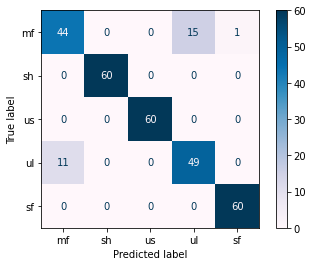

In [20]:
import sklearn.metrics as metrics
ref = gpd.read_file('/content/drive/MyDrive/Uni/Geographie/BA/Klassifikation/Hue_REFERENCE_CLASSES_preprocessed.csv')
ref.FID = ref.FID.astype(np.int64)
data_classified_full = gpd.read_file(outfile_classified)
data_classified_full.FID = data_classified_full.FID.astype(np.int64)

pred = ref.drop(columns='class_name').merge(data_classified_full[['class_name', 'FID']], on='FID')
labels = list(set(pred.class_name))
confusion_matrix = metrics.confusion_matrix(ref.class_name, pred.class_name, normalize=None, labels=labels)

metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=labels).plot(cmap='PuBu')


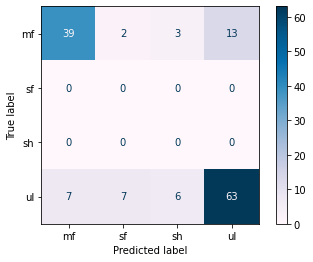

In [21]:
# Accuracy on test date
import sklearn.metrics as metrics
classes_in = "/content/drive/MyDrive/Uni/Geographie/BA/Klassifikation/V_2_Hue_Training_Classes_no_params.csv"
training_classes_mful = gpd.read_file(classes_in)
training_classes_mful.FID = training_classes_mful.FID.astype(np.int64)
training_classes_mful = training_classes_mful[(training_classes_mful.class_name == 'mf') | (training_classes_mful.class_name == 'ul')]
data_classified_full = gpd.read_file(outfile_classified)
data_classified_full.FID = data_classified_full.FID.astype(np.int64)

pred = training_classes_mful.drop(columns='class_name').merge(data_classified_full[['class_name', 'FID']], on='FID')
labels = list(set(pred.class_name))
confusion_matrix = metrics.confusion_matrix(training_classes_mful.class_name, pred.class_name, normalize=None, labels=labels)

metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=labels).plot(cmap='PuBu')


#  Test Area

---



In [ ]:
# data = gpd.read_file(outfile_classified)

# us = len(data[data.class_name == 'us'])
# sh = len(data[data.class_name == 'sh'])
# sf = len(data[data.class_name == 'sf'])
# mf = len(data[data.class_name == 'mf'])
# ul = len(data[data.class_name == 'ul'])
# mf+ul
# len(data[data.area <= 25])
# print('us  = ',us,'\nsh  = ',sh,'\nsf  = ',sf,'\nmf  =  ',mf,'\nul  =  ',ul,'\n------------','\nsum =',len(data))

In [ ]:
# len(buildings_in_block[buildings_in_block.class_name.isna()]) / len(data[data.bID == buildings_in_block.iloc[0].bID])
# buildings_in_block.iloc[0, 'bID']
# len(data[data.bID == buildings_in_block.iloc[0].bID])
# max(data_mful.b_mful_rat)
# len(training_classes_mful[training_classes_mful.class_name == 'ul'])
# data_mful[data_mful.b_mful_rat > 0.3]

# test = mp.preprocess(data_mful, size=9999999)
# test.to_file('/content/drive/MyDrive/Uni/Geographie/BA/Daten/Hue_MFUL_w_params_dissolved.shp')